In [7]:
import sqlite3
import pandas as pd
from pathlib import Path

# Point this to your repo root (or just hardcode the absolute path)
REPO_ROOT = Path(r"/Users/ale/Documents/Code Projects/openpoke")
print(True if REPO_ROOT.exists() else False)
DB_PATH = REPO_ROOT / "server" / "data" / "telemetry" / "llm_usage.sqlite"

conn = sqlite3.connect(DB_PATH)

# Show tables
tables = pd.read_sql_query(
    "SELECT name FROM sqlite_master WHERE type='table' ORDER BY name;",
    conn
)
display(tables)

True


,name
0,llm_usage
1,sqlite_sequence


In [9]:
# Print the last 200 rows (most recent first)
df = pd.read_sql_query(
    """
    SELECT *
    FROM llm_usage
    WHERE root_source = "user_request"
    ORDER BY ts_utc
    LIMIT 200;
    """,
    conn
)

display(df)

,id,ts_utc,trace_id,root_source,component,agent_name,purpose,span_id,parent_span_id,model,duration_ms,status,http_status,prompt_tokens,completion_tokens,total_tokens,cost,error
0,1,2026-01-26T18:15:21.624664+00:00,user_request_c45d3763bd19,user_request,interaction_agent,NaN,interaction_agent.query_decomposition,3d384381b24849e3,NaN,anthropic/claude-sonnet-4,1028,ok,200,429,8,437,0.001407,None
1,2,2026-01-26T18:15:24.078159+00:00,user_request_c45d3763bd19,user_request,interaction_agent,NaN,interaction_agent.loop,f1b4f82bba7d47ed,3d384381b24849e3,anthropic/claude-sonnet-4,2437,ok,200,3341,77,3418,0.011178,None
2,3,2026-01-26T18:15:24.807744+00:00,user_request_c45d3763bd19,user_request,interaction_agent,NaN,interaction_agent.loop,3d3e4ded530b489c,f1b4f82bba7d47ed,anthropic/claude-sonnet-4,725,ok,200,3487,2,3489,0.010491,None
3,4,2026-01-26T18:16:41.479604+00:00,user_request_3a754619b6b0,user_request,interaction_agent,NaN,interaction_agent.query_decomposition,40e0c2ad3657456a,NaN,anthropic/claude-sonnet-4,1269,ok,200,515,12,527,0.001725,None
4,5,2026-01-26T18:16:43.318203+00:00,user_request_3a754619b6b0,user_request,interaction_agent,NaN,interaction_agent.loop,1ecbe3e72b4f4f1c,40e0c2ad3657456a,anthropic/claude-sonnet-4,1835,ok,200,3427,71,3498,0.011346,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147,164,2026-01-27T20:27:51.581597+00:00,user_request_1a4f868df796,user_request,interaction_agent,NaN,interaction.loop,c67094cf751746f2,b345f22c08654c4e,anthropic/claude-sonnet-4,2058,ok,200,784,121,905,0.004167,None
148,165,2026-01-27T20:38:35.781501+00:00,user_request_08b440999902,user_request,interaction_agent,NaN,interaction_agent.query_decomposition,9fa863865f434209,NaN,anthropic/claude-sonnet-4,1055,ok,200,958,16,974,0.003114,None
149,166,2026-01-27T20:38:38.534076+00:00,user_request_08b440999902,user_request,interaction_agent,NaN,interaction_agent.loop,4630a77452e24197,9fa863865f434209,anthropic/claude-sonnet-4,1902,ok,200,5180,63,5243,0.016485,None
150,167,2026-01-27T20:38:39.431677+00:00,user_request_08b440999902,user_request,interaction_agent,NaN,interaction_agent.loop,80105ff4e5ad49a7,4630a77452e24197,anthropic/claude-sonnet-4,894,ok,200,5298,2,5300,0.015924,None


# Example analyses

### How much is each entry point that causes an llm call costing?

In [3]:
df = pd.read_sql_query(
    """
    SELECT
      root_source,
      COUNT(DISTINCT trace_id) AS events,
      ROUND(SUM(COALESCE(cost, 0)), 6) AS total_cost,
      ROUND(SUM(COALESCE(cost, 0)) / NULLIF(COUNT(DISTINCT trace_id), 0), 6) AS avg_cost_per_event,
      SUM(COALESCE(total_tokens, 0)) AS total_tokens
    FROM llm_usage
    WHERE trace_id IS NOT NULL
    GROUP BY root_source
    ORDER BY total_cost DESC;
    """,
    conn
)

display(df)

,root_source,events,total_cost,avg_cost_per_event,total_tokens
0,user_request,5,0.988020,0.197604,318044
1,trigger,2,0.203379,0.101690,65401
2,email_monitor,1,0.084255,0.084255,27081
3,summarizer,1,0.032385,0.032385,8651


### On average, how expensive is a single user request end-to-end?

In [4]:
df = pd.read_sql_query(
    """
    SELECT
      COUNT(DISTINCT trace_id) AS user_requests,
      ROUND(SUM(COALESCE(cost, 0)), 6) AS total_cost,
      ROUND(SUM(COALESCE(cost, 0)) / NULLIF(COUNT(DISTINCT trace_id), 0), 6) AS avg_cost_per_user_request
    FROM llm_usage
    WHERE root_source = 'user_request'
      AND trace_id IS NOT NULL;
    """,
    conn
)

display(df)

,user_requests,total_cost,avg_cost_per_user_request
0,5,0.98802,0.197604


### Within this one request (triggered an email search), how does cost break down?

In [5]:
df = pd.read_sql_query(
    """
SELECT
      purpose,
      COUNT(*) AS calls,
      ROUND(SUM(COALESCE(cost, 0)), 6) AS total_cost,
      SUM(COALESCE(total_tokens, 0)) AS total_tokens
    FROM llm_usage
    WHERE trace_id = :trace_id
    GROUP BY purpose
    ORDER BY total_cost DESC;
    """,
    conn,
    params={"trace_id": "user_request_82ff98f3ec4a"}
)

display(df)

,purpose,calls,total_cost,total_tokens
0,interaction_agent.loop,3,0.112512,36740
1,interaction_agent.post_exec,1,0.038280,12304
2,execution_agent.loop,2,0.037857,11367
3,tool.task_email_search,2,0.021660,5912
4,interaction_agent.query_decomposition,1,0.003060,928
5,execution_agent.metadata.generate_description,1,0.002118,494


### Visualize dependency structure of a single trace ID call flow

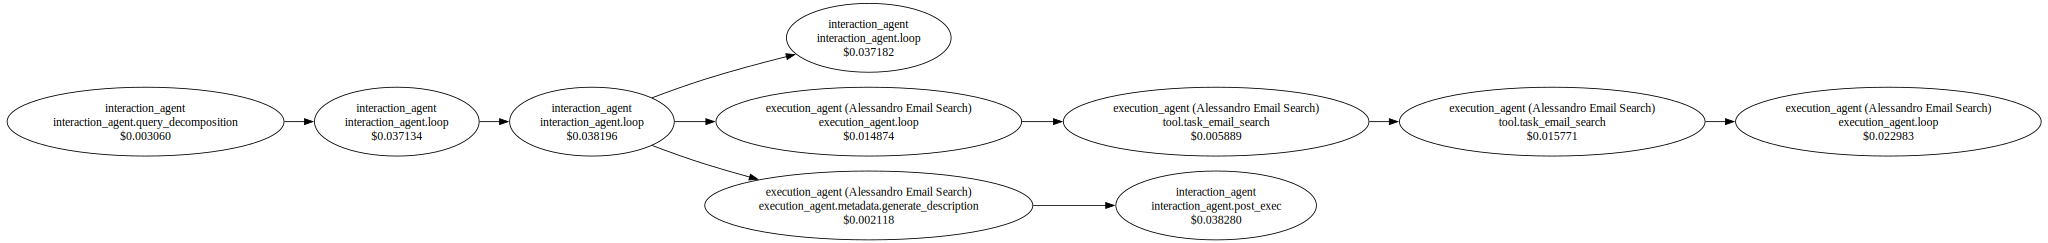

In [6]:
df = pd.read_sql_query(
    """
    SELECT ts_utc, component, agent_name, purpose, span_id, parent_span_id, cost
    FROM llm_usage
    WHERE trace_id = "user_request_82ff98f3ec4a"
    ORDER BY ts_utc ASC
    """,
    conn,
)

### NOTE: You need to have graphviz installed on your system for this to work, not just in your python environment.
from graphviz import Digraph

dot = Digraph("trace", graph_attr={"rankdir":"LR"})

for _, r in df.iterrows():
    who = r["component"] + (f" ({r['agent_name']})" if r["agent_name"] else "")
    cost = 0 if r["cost"] is None else float(r["cost"])
    dot.node(str(r["span_id"]), f"{who}\n{r['purpose']}\n${cost:.6f}")

for _, r in df.iterrows():
    if r["parent_span_id"]:
        dot.edge(str(r["parent_span_id"]), str(r["span_id"]))

display(dot)

In [7]:
conn.close()